(1) ---

(2) ---

(3) ---

(4) Initialization.

In [1]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.serialization import load_pem_public_key
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

logging.basicConfig(filename="log.txt", level=logging.DEBUG);

(5) Receive ControlER public key bytes from the communication channel.

In [2]:
with open('channel', 'rb') as f:
    cont_public_key_bytes = f.read();
logging.debug(" Delentture: Loaded the ControlER public key bytes from the channel.");

(6) Get the same parameters to use in DH algorithm that were used by ControlER. We use the ControlER public key for that, to simulate agreement between parties.

In [3]:
cont_public_key = load_pem_public_key(cont_public_key_bytes, default_backend())
logging.debug(" Delentture: Created the ControlER public key from the loaded bytes.");

parameters = cont_public_key.parameters();
logging.debug(" Delentture: Loaded the agreed parameters contained in the public key.");

(7) Create Delentture public key. Create Delentture Private key

In [4]:
dele_private_key = parameters.generate_private_key();
logging.debug(" Delentture: Generated the private key.");

dele_public_key = dele_private_key.public_key();
logging.debug(" Delentture: Generated the public key.");

# If parameter values for generation are the same, continue
assert dele_public_key.parameters().parameter_numbers().p == cont_public_key.parameters().parameter_numbers().p;
assert dele_public_key.parameters().parameter_numbers().g == cont_public_key.parameters().parameter_numbers().g;

(8) Generate the shared key between the two parties. In this end - a mix of ControlER public key and Delentture private key

In [5]:
shared_key = dele_private_key.exchange(cont_public_key);

logging.debug(" Delentture: Generated the shared key:");
logging.info(shared_key);

(9) Write Delentture public key in bytes and send in the communication channel.

In [6]:
dele_public_key_bytes = dele_public_key.public_bytes(serialization.Encoding.PEM, serialization.PublicFormat.SubjectPublicKeyInfo);
with open('channel', 'wb') as f:
    f.write(dele_public_key_bytes)
    f.close()
    
logging.debug(" Delentture: Sent the public key public key to the communication server.");

(10) ---

(11) ---

(12) ---

(13) ---

(14) ---

(15) ---

(16) Hashing - generate secret cipher key (from the shared key between two parties) and secret nonce

In [7]:
secret_key = HKDF(
    algorithm=hashes.SHA256(),
    length=32, # 32 bytes is the highest level of encryption for AES-GCM
    salt=None,
    info=b'secret', # handshake data
).derive(shared_key)

logging.debug(" Delentture: Generated the secret key:");
logging.info(secret_key);

nonce = HKDF(
    algorithm=hashes.SHA256(),
    length=12, # must use 12 bits, because the AES-GCM operates on nonces with 12 bytes.
    salt=None,
    info=b'nonce', # handshake data
).derive(secret_key);

logging.debug(" Delentture: Generated the secret nonce:");
logging.info(nonce);

(17) Receive original dataset ciphertext from the communication file

In [8]:
with open('channel', 'rb') as f:
    original_dataset_ciphertext = f.read();
logging.debug(" Delentture: Received the original dataset ciphertext of the encrypted dataset.");

(18) Decrypt the original dataset ciphertext to a decrypted dataset and save it

In [9]:
aesgcm = AESGCM(secret_key);

decrypted_dataset_bytes = aesgcm.decrypt(nonce, original_dataset_ciphertext, secret_key);

#try:
#    aesgcm.decrypt(nonce, ciphertext, None);
#except:
#    print("Sabe a chave secreta, mas nao sabe o nounce");
#    
#try:
#    aesgcm.decrypt(None, ciphertext, secret_key);
#except:
#    print("Sabe o nounce mas nao sabe a chave secreta");

with open('decrypted_dataset.csv', 'wb') as f:
    f.write(decrypted_dataset_bytes)
    
logging.debug(" Delentture: Decrypted and saved the original dataset.");

(19) ---

(20) Do the same for the original description.

In [10]:
with open('channel', 'rb') as f:
    original_description_ciphertext = f.read();
logging.debug(" Delentture: Received the original description ciphertext of the encrypted dataset.");

decrypted_description_bytes = aesgcm.decrypt(nonce, original_description_ciphertext, secret_key);

with open('decrypted_description.csv', 'wb') as f:
    f.write(decrypted_description_bytes)
    
logging.debug(" Delentture: Decrypted and saved the original description.");

(21) Perform two different data analysis and save as PDF.

In [ ]:
df = pd.read_csv("decrypted_dataset.csv");

# row = person, column = values
# locate row: df.loc[1]
# selecionar as linhas que infrigiram e que não infrigiram
# cria uma Dataframe para cada caso
sel1 = df[df["infringed"] == 1]
sel2 = df[df["infringed"] == 0]

# definir variáveis para os gráficos

past_annuity = [sel2["past_avg_amount_annuity"].mean(), sel1["past_avg_amount_annuity"].mean()]
past_application = [sel2["past_avg_amt_application"].mean(), sel1["past_avg_amt_application"].mean()]
past_credit = [sel2["past_avg_amt_credit"].mean(), sel1["past_avg_amt_credit"].mean()]
past_approved = [sel2["past_loans_approved"].mean(), sel1["past_loans_approved"].mean()]
past_cancelled = [sel2["past_loans_canceled"].mean(), sel1["past_loans_canceled"].mean()]
past_refused = [sel2["past_loans_refused"].mean(), sel1["past_loans_refused"].mean()]
past_total = [sel2["past_loans_total"].mean(), sel1["past_loans_total"].mean()]
past_unused = [sel2["past_loans_unused"].mean(), sel1["past_loans_unused"].mean()]

#print(past_application);

#plt.bar(["infrigiu", "não infrigiu"], past_annuity)
#plt.show()

fig, axs = plt.subplots(2, 4)
fig.tight_layout(pad=1.1)
axs[0, 0].bar(["sim", "não"], past_annuity)
axs[0, 0].set_title("Average annuity", fontsize=10)
axs[0, 1].bar(["sim", "não"], past_application)
axs[0, 1].set_title("Average application", fontsize=10)
axs[1, 0].bar(["sim", "não"], past_credit)
axs[1, 0].set_title("average credit", fontsize=10)
axs[1, 0].set(xlabel = "infrigiu")
axs[1, 1].bar(["sim", "não"], past_approved)
axs[1, 1].set_title("Loans approved", fontsize=10)
axs[1, 1].set(xlabel = "infrigiu")
axs[0, 2].bar(["sim", "não"], past_cancelled)
axs[0, 2].set_title("Loans cancelled", fontsize=10)
axs[0, 3].bar(["sim", "não"], past_refused)
axs[0, 3].set_title("Loans refused", fontsize=10)
axs[1, 2].bar(["sim", "não"], past_total)
axs[1, 2].set_title("Loans total", fontsize=10)
axs[1, 2].set(xlabel = "infrigiu")
axs[1, 3].bar(["sim", "não"], past_unused)
axs[1, 3].set_title("Loans unnused", fontsize=10)
axs[1, 3].set(xlabel = "infrigiu")
#plt.show()

fig.savefig("plot1.pdf")

<Figure size 432x288 with 0 Axes>

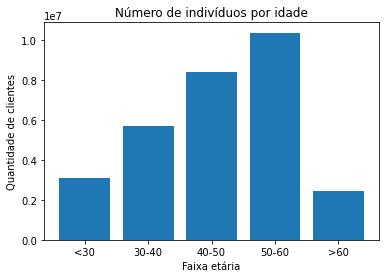

In [17]:
age1 = df[df["age"] < 30].size
age2 = df[df["age"] < 40].size - age1
age3 = df[df["age"] < 50].size - age2
age4 = df[df["age"] < 60].size - age3
age5 = df[df["age"] >= 60].size

plt.clf()
fig = plt.figure();
plt.bar(["<30", "30-40", "40-50", "50-60", ">60"], [age1, age2, age3, age4, age5])
plt.title("Número de indivíduos por idade")
plt.xlabel('Faixa etária')
plt.ylabel('Quantidade de clientes')
#plt.show()
fig.savefig("plot2.pdf")

(22) Encrypt and send the first data analysis pdf.

In [16]:
with open('plot1.pdf', 'rb') as f:
    original_plot1 = f.read();
    
plot1_ciphertext = aesgcm.encrypt(nonce, original_plot1, secret_key);
logging.debug(" Delentture: Encrypted the plot1 pdf.");

with open('channel', 'wb') as f:
    f.write(plot1_ciphertext);
    f.close()
    
logging.debug(" Delentture: Sent the encrypted plot1 pdf to the communication channel successfuly.");

(23) ---

(24) Encrypt and send the second data analysis pdf.

In [ ]:
with open('plot2.pdf', 'rb') as f:
    original_plot2 = f.read();
    
plot2_ciphertext = aesgcm.encrypt(nonce, original_plot2, secret_key);
logging.debug(" Delentture: Encrypted the plot2 pdf.");

with open('channel', 'wb') as f:
    f.write(plot2_ciphertext);
    f.close()
    
logging.debug(" Delentture: Sent the encrypted plot2 pdf to the communication channel successfuly.");

(25) ---